# Prediction of Pneumonia from chest X-rays images

In this project we will find an algorithm that automatically predicts pneumonia from chest X-rays provided. We will be performing data processing, then applying model and finally comparing the models and visulaizing which model is best for achieving high accuracy.

In [110]:
##Imporiting the libraries required for the project

import numpy as np
import os
import pandas as pd

import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim


from sklearn.metrics import confusion_matrix, precision_recall_fscore_support,accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import shuffle


import scipy.ndimage
from scipy import misc
from scipy import stats

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.metrics import *
from keras.applications.resnet50 import ResNet50
from keras.layers import GlobalMaxPooling2D
from keras.models import Model

import glob
from glob import glob
import skimage
import imageio
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

#To check if the system has cuda tool installed or not
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Loading Metadata

The data sets choosen has different folders namely test and train data. The metadata file gives information about images and their category under which they fall. 'Label' say whether the X-ray image are of normal person or pnuemonia person. using this we can train our model and get best results  

In [114]:
# importing metadata

#getcwd gives the correct working directory.
data_dir = os.getcwd() + "/coronahack-chest-xraydataset"
metadata = pd.read_csv(data_dir + '/Chest_xray_Corona_Metadata.csv')

# label encoding the two classes
le = LabelEncoder()
le.fit(metadata['Dataset_type'])
LabelEncoder()
print("Classes:", list(le.classes_))  

#separating the training and testing data
metadata['label'] = le.transform(metadata["Dataset_type"]) 
train_data = metadata[metadata['Dataset_type'] == 'TRAIN']
test_data = metadata[metadata['Dataset_type'] == 'TEST']

#Spliting the records into normal vs pneumonia records
healthy_records = metadata[metadata['Label'] == 'Normal']
infected_records = metadata[metadata['Label'] == 'Pnemonia']

#printing number of records to understand the data available
assert train_data.shape[0] + test_data.shape[0] == metadata.shape[0]
print(f"\nShape of train data : {train_data.shape}")
print(f"Shape of test data : {test_data.shape}")

print(f"\nNumber of records of Healthy people : {healthy_records.shape}")
print(f"Number of records of Pnemonia infected people: {infected_records.shape}")

#displaying sample data.
metadata.sample(10)

Classes: ['TEST', 'TRAIN']

Shape of train data : (5286, 7)
Shape of test data : (624, 7)

Number of records of Healthy people : (1576, 7)
Number of records of Pnemonia infected people: (4334, 7)


,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category,label
2603,2603,person1534_virus_2670.jpeg,Pnemonia,TRAIN,NaN,Virus,1
2509,2509,person1582_bacteria_4142.jpeg,Pnemonia,TRAIN,NaN,bacteria,1
702,702,NORMAL2-IM-0506-0001.jpeg,Normal,TRAIN,NaN,NaN,1
2972,2972,person255_bacteria_1182.jpeg,Pnemonia,TRAIN,NaN,bacteria,1
3204,3204,person310_virus_633.jpeg,Pnemonia,TRAIN,NaN,Virus,1
3855,3855,person402_bacteria_1810.jpeg,Pnemonia,TRAIN,NaN,bacteria,1
5793,5816,person63_virus_121.jpeg,Pnemonia,TEST,NaN,Virus,0
5788,5811,person69_virus_129.jpeg,Pnemonia,TEST,NaN,Virus,0
5278,5297,1-s2.0-S1684118220300608-main.pdf-002.jpg,Pnemonia,TRAIN,COVID-19,Virus,1
2955,2955,person258_bacteria_1208.jpeg,Pnemonia,TRAIN,NaN,bacteria,1


As we can see that the records have empty values which are of no use. so the cleaning of data must be done to achieve high accuracy. To do so we have replaced the null values with the string 'unknown'

In [4]:
# Substitute null values with string unknown
train_fill = train_data.fillna('unknown')
test_fill = test_data.fillna('unknown')

#displayig sample data after cleaning
train_fill.sample(10)

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category,label
1995,1995,person1310_bacteria_3302.jpeg,Pnemonia,TRAIN,unknown,bacteria,1
4408,4408,person537_bacteria_2263.jpeg,Pnemonia,TRAIN,unknown,bacteria,1
992,992,NORMAL2-IM-0977-0001.jpeg,Normal,TRAIN,unknown,unknown,1
3317,3317,person287_bacteria_1354.jpeg,Pnemonia,TRAIN,unknown,bacteria,1
810,810,NORMAL2-IM-0672-0001.jpeg,Normal,TRAIN,unknown,unknown,1
3795,3795,person41_bacteria_208.jpeg,Pnemonia,TRAIN,unknown,bacteria,1
3926,3926,person515_bacteria_2185.jpeg,Pnemonia,TRAIN,unknown,bacteria,1
4044,4044,person487_bacteria_2060.jpeg,Pnemonia,TRAIN,unknown,bacteria,1
3410,3410,person383_bacteria_1747.jpeg,Pnemonia,TRAIN,unknown,bacteria,1
4974,4974,person745_virus_1368.jpeg,Pnemonia,TRAIN,unknown,Virus,1


# Data Visualization

For better understanding of data distribution we have used visualization techniques. plotting graphs helps us understand relationship and distribution among the columns in metadata.

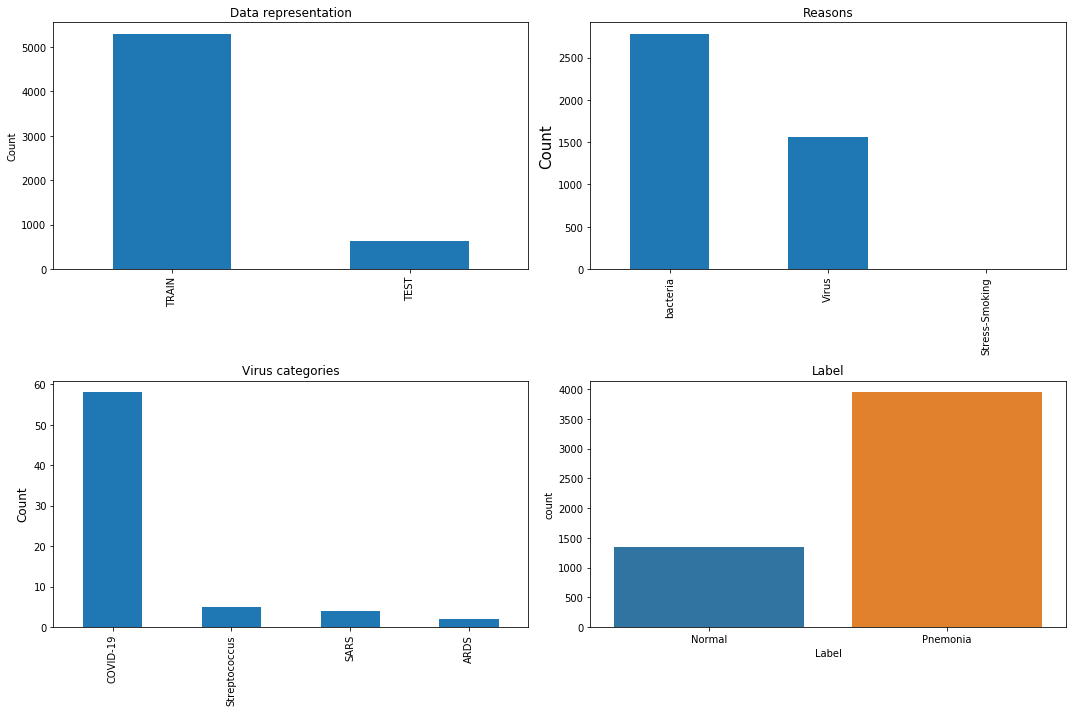

In [5]:
# Getting a sense of what the distribution of each column looks like
fig = plt.figure(figsize=(15,10))

#plot graph between train vs test data
ax1 = fig.add_subplot(221)
metadata['Dataset_type'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Data representation');

#plot graph to understand data distribution using 'Label_1_virus' column
ax2 = fig.add_subplot(222)
metadata['Label_1_Virus_category'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Reasons');

#plot graph to understand data distribution using 'Label_2_virus' column
ax3 = fig.add_subplot(223)
metadata['Label_2_Virus_category'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Virus categories')

#plot graph between Normal Vs pneumonia labels
ax4 = fig.add_subplot(224)
sample_age = metadata[pd.notnull(metadata['Label'])]
sns.countplot(x='Label', data=train_fill)
ax4.set_title('Label')

#displaying the graphs

plt.tight_layout()
plt.show()

Since we have seen that virus categories are of 4 types. We will load the images and arrange them according to the categories. By this we can find similarities between the same category images.

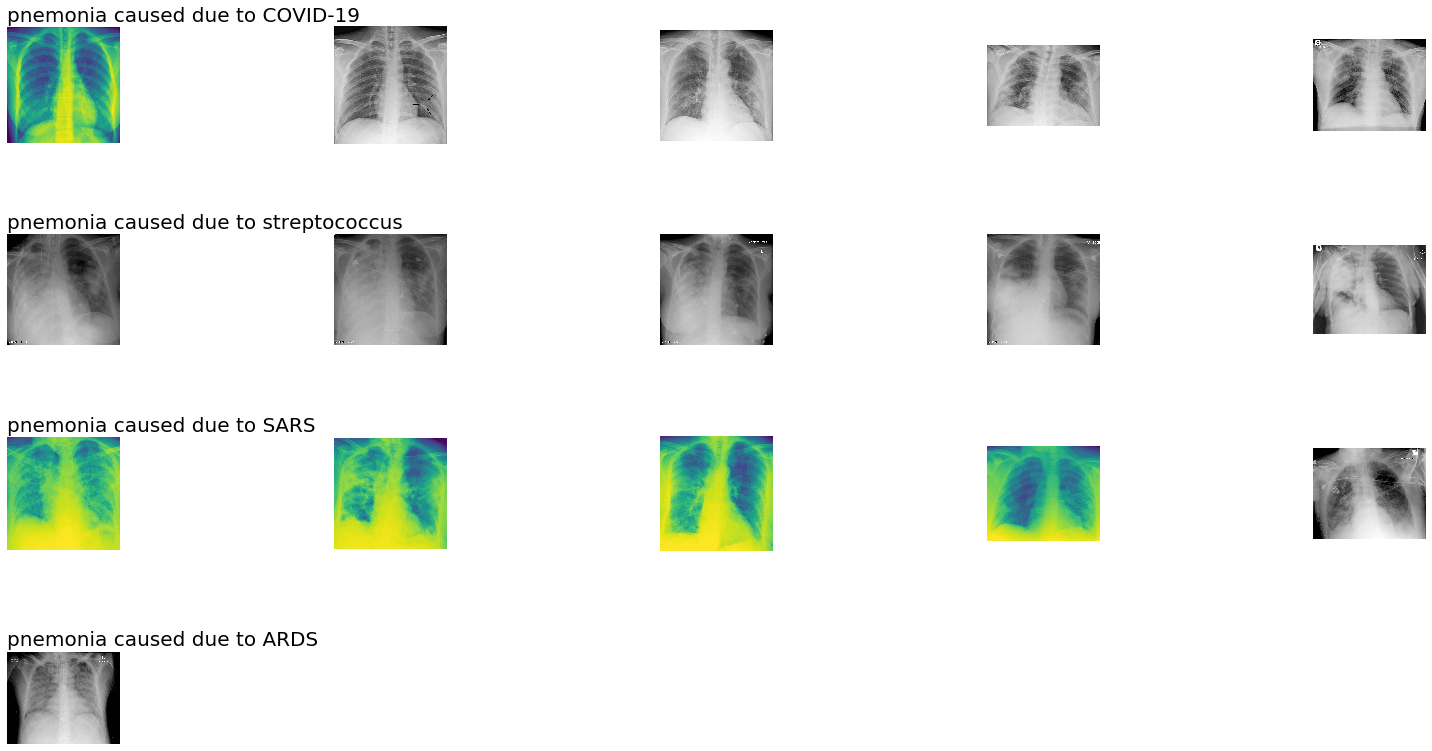

In [6]:

#intializing labels for spliting into categories
label = [ 'COVID-19', 'Streptococcus','SARS','ARDS']

#setting the path to fetch the images
data_dir = os.getcwd() + "/coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset\Coronahack-Chest-XRay-Dataset"

#classes are descriptions for categories to display
label_images = []
classes = [ 'pnemonia caused due to COVID-19', 'pnemonia caused due to streptococcus', 'pnemonia caused due to SARS',
           'pnemonia caused due to ARDS' ]


#plotting the figures based on categories
fig = plt.figure(figsize=(20, 20))
k = range(7)

#looping through metadata and getting the first five images
for i in label:
    sample = metadata[metadata['Label_2_Virus_category'] == i]['X_ray_image_name'][:5]
    label_images.extend(sample)

#Fetching the images from the folders downloaded    
for position,ID in enumerate(label_images):
    labl = metadata[metadata['X_ray_image_name'] == ID]['Label_2_Virus_category']
    category = metadata[metadata['X_ray_image_name'] == ID]['Dataset_type']
    
    #imageio.imread method is used to load the images from given path
    im_sample = data_dir + "/" + (category.values[0]).lower() + "/" + ID
    im_sample = imageio.imread(im_sample)

    plt.subplot(7,5,position+1)
    plt.imshow(im_sample)
    plt.axis('off')

    if position%5 == 0:
        title = int(position/5)
        plt.title(classes[title], loc='left', size=20)

#displaying fetched records
plt.tight_layout()
plt.show()



Histograms helps in better understanding the tonal distribution of the image. this helps in seggregating images based on tonal distribution. the normal and pneumonia infected persons histograms are shown below. We can say that pneumonia infected persons histograms are Left skewed where as normal persons chest x ary histogram will be right-skewed.

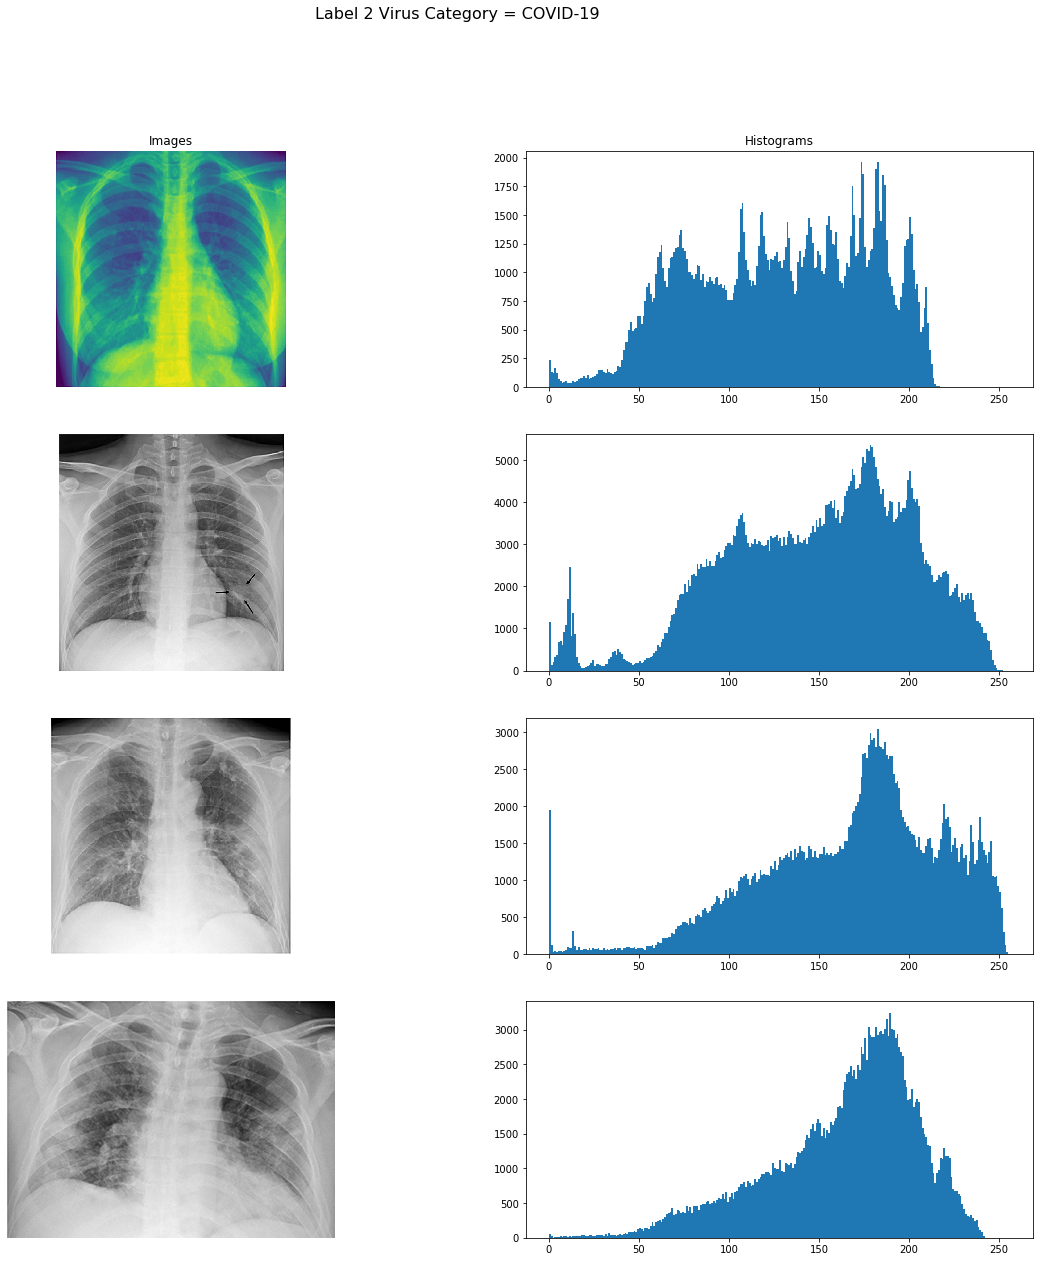

In [7]:
# Plot b/w image histograms of Label_2_Virus_category type "COVID-19" patients 

#storing the test and train images paths
TRAIN_FOLDER = data_dir + "/train"
TEST_FOLDER = data_dir + "/test"

#initializing plots for display
fig, ax = plt.subplots(4, 2, figsize=(20, 20))

#displaying for images that fall under COVID-19 category
covid19_type_file_paths = train_data[train_data['Label_2_Virus_category'] == 'COVID-19']['X_ray_image_name'].values
sample_covid19_file_paths = covid19_type_file_paths[:4]
sample_covid19_file_paths = list(map(lambda x: os.path.join(TRAIN_FOLDER, x), sample_covid19_file_paths))

#fetching the image from the folder
for row, file_path in enumerate(sample_covid19_file_paths):
    image = plt.imread(file_path)
    ax[row, 0].imshow(image)
    #Creating histogram for the image by using hist() method
    ax[row, 1].hist(image.ravel(), 256, [0,256])
    ax[row, 0].axis('off')
    
    if row == 0:
        ax[row, 0].set_title('Images')
        ax[row, 1].set_title('Histograms')

#Displaying both images and histograms       
fig.suptitle('Label 2 Virus Category = COVID-19', size=16)
plt.show()


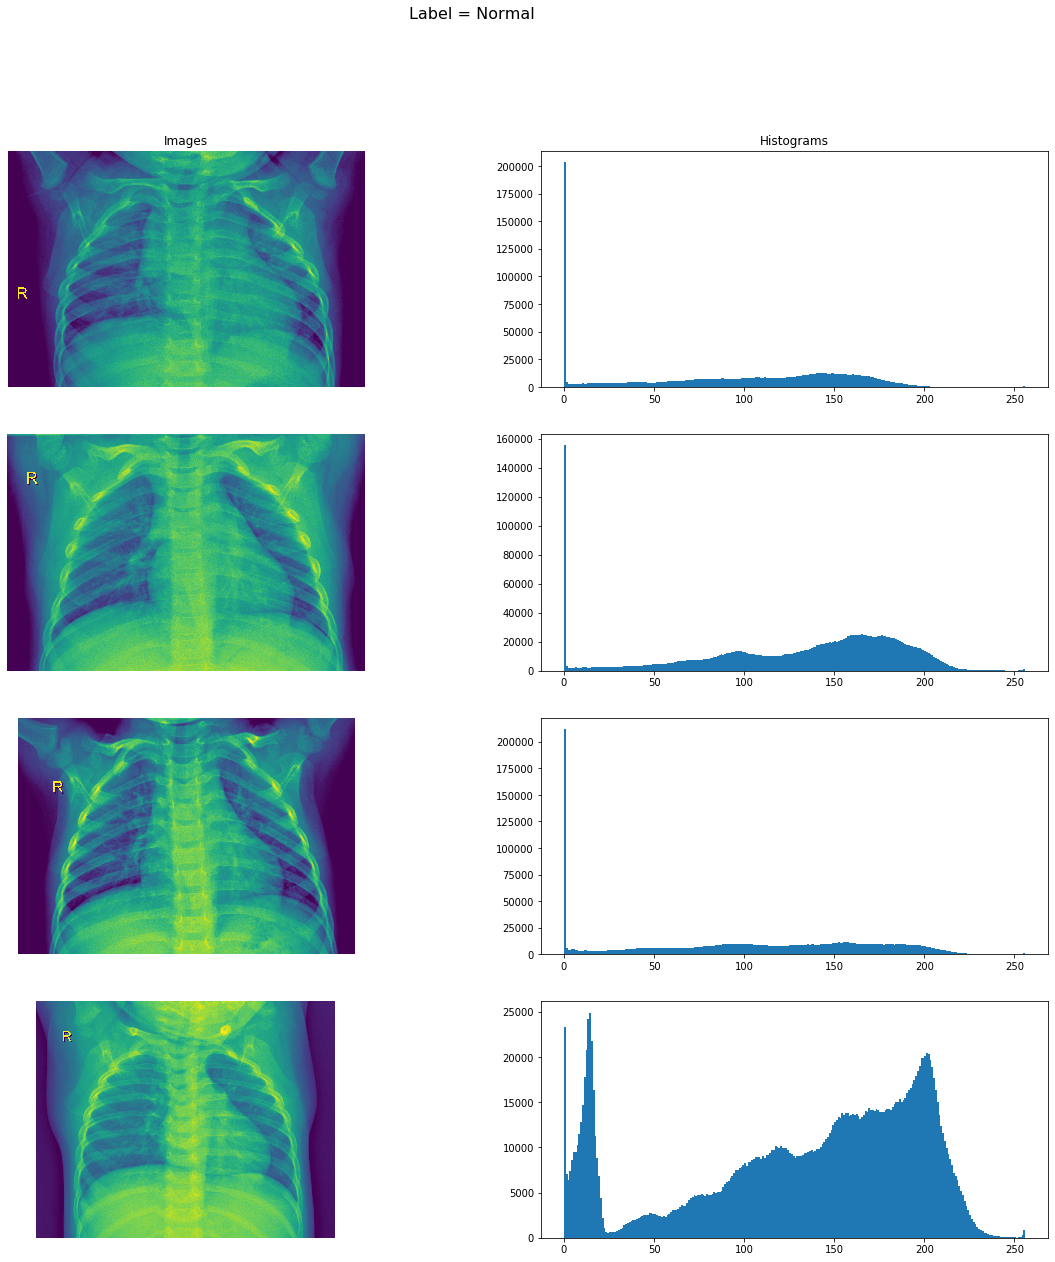

In [8]:
# Plot b/w image histograms of Label type "Normal" patients 

#initializing plots for display
fig, ax = plt.subplots(4, 2, figsize=(20, 20))

#fetching records whose label falls under category 'Normal'
other_type_file_paths = train_data[train_data['Label'] == 'Normal']['X_ray_image_name'].values
sample_other_file_paths = other_type_file_paths[:4]
sample_other_file_paths = list(map(lambda x: os.path.join(TRAIN_FOLDER, x), sample_other_file_paths))

#fetching the images from the folders
for row, file_path in enumerate(sample_other_file_paths):
    image = plt.imread(file_path)
    ax[row, 0].imshow(image)
    #creating histogram for the fetched image
    ax[row, 1].hist(image.ravel(), 256, [0,256])
    ax[row, 0].axis('off')
    
    if row == 0:
        ax[row, 0].set_title('Images')
        ax[row, 1].set_title('Histograms')
        
#displaying images vs histograms        
fig.suptitle('Label = Normal', size=16)
plt.show()

# Data Augmentation

We have to first split the data into training, validation and test data. then we should perform data augmenattion.

In [100]:
# Generate the final train data from original train data with conditions refered from EDA inference

final_train_data = train_data[(train_data['Label'] == 'Normal') | 
                              (train_data['Label'] == 'Pnemonia')]

# Create a target attribute where value = positive if 'Pnemonia + COVID-19' or value = negative if 'Normal'
final_train_data['target'] = ['negative' if holder == 'Normal' else 'positive' for holder in final_train_data['Label']]

#shuffling the data.this step is not mandatory
final_train_data = shuffle(final_train_data, random_state=1)

#spliting the training data set into training and validation data set
final_validation_data = final_train_data.iloc[1000:, :]
final_train_data = final_train_data.iloc[:1000, :]

#displaying the train_data after spliting
print(f"Final train data shape : {final_train_data.shape}")
final_train_data.sample(10)

Final train data shape : (1000, 8)


,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category,label,target
867,867,NORMAL2-IM-0694-0001.jpeg,Normal,TRAIN,NaN,NaN,1,negative
1501,1501,person1093_bacteria_3033.jpeg,Pnemonia,TRAIN,NaN,bacteria,1,positive
2803,2803,person1639_bacteria_4345.jpeg,Pnemonia,TRAIN,NaN,bacteria,1,positive
2600,2600,person1535_bacteria_4017.jpeg,Pnemonia,TRAIN,NaN,bacteria,1,positive
1942,1942,person1324_virus_2285.jpeg,Pnemonia,TRAIN,NaN,Virus,1,positive
1125,1125,NORMAL2-IM-1125-0001.jpeg,Normal,TRAIN,NaN,NaN,1,negative
1185,1185,NORMAL2-IM-1204-0001.jpeg,Normal,TRAIN,NaN,NaN,1,negative
4290,4290,person566_virus_1106.jpeg,Pnemonia,TRAIN,NaN,Virus,1,positive
2093,2093,person1439_virus_2453.jpeg,Pnemonia,TRAIN,NaN,Virus,1,positive
2415,2415,person1462_virus_2512.jpeg,Pnemonia,TRAIN,NaN,Virus,1,positive


In [101]:
#spliting into training , validation and test data

#To perform Data augmentation on train_Data
train_image_generator = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=90,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True,
    zoom_range=[0.9, 1.25],
    brightness_range=[0.5, 1.5]
)

#Rescaling the test_data as well to match the scaling of training data
test_image_generator = ImageDataGenerator(
    rescale=1./255
)

#reading images from data for training
train_generator = train_image_generator.flow_from_dataframe(
    dataframe=final_train_data,
    directory=TRAIN_FOLDER,
    x_col='X_ray_image_name',
    y_col='target',
    target_size=(224, 224),
    batch_size=8,
    seed=2020,
    shuffle=True,
    class_mode='binary'
)

#reading images from dataframe for forming validation data
validation_generator = train_image_generator.flow_from_dataframe(
    dataframe=final_validation_data,
    directory=TRAIN_FOLDER,
    x_col='X_ray_image_name',
    y_col='target',
    target_size=(224, 224),
    batch_size=8,
    seed=2020,
    shuffle=True,
    class_mode='binary'
)

#reading data from dataframe for forming test data
test_generator = test_image_generator.flow_from_dataframe(
    dataframe=test_data,
    directory=TEST_FOLDER,
    x_col='X_ray_image_name',
    #the y_col will be none here which will be predicted by the model
    y_col='none',
    target_size=(224, 224),
    shuffle=False,
    batch_size=16,
    class_mode=None
)



Found 1000 validated image filenames belonging to 2 classes.
Found 4286 validated image filenames belonging to 2 classes.
Found 624 validated image filenames.


# Training Base CNN model

The sequential model is base model of CNN. It helps to build model layer by layer. Each layer will have weight assigned which will be carried forward to next layer. We first by using convolutional layer followed by max pooling layer. The activation function used is Relu. This is continued till 3 layers the flatten and dense the layers. To train the data we use optimizer named Adam() and loss function as cross entropy

The functions required for training data will be described. The learningRateScheduler is used for calling the epoches based on the loss function and optimizer used. it chooses the leraning rate to minimize the loss function. this helps in covering the data that will help in getting more accuracy

In [11]:
#initilaize the functions and varibales used in displaying epoches

#function used for determing learning rate 
def scheduler(epoch):
    
    #starting the learning rate from 0.0001
    if epoch < 5:
        return 0.0001
    else:
        
        #setting the rate based on negative point obtained in training
        print(f"Learning rate reduced to {0.0001 * np.exp(0.5 * (5 - epoch))}")
        return 0.0001 * np.exp(0.5 * (5 - epoch))
    
#LearningRateScheduler returns the learning rate to use in stochastic gradient descent
custom_callback = LearningRateScheduler(scheduler)

#defining metrics that will displayed while training happens
METRICS = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'), 
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='auc'),
     ]

In [ ]:
##Training the model 

#Defining the layers for model
model = Sequential([
    Conv2D(64, (3, 3), input_shape=(224, 224, 3), activation='relu'),
    MaxPooling2D((3, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((3, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((3, 3)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

#Adding optimizer and loass function for the model
model.compile(optimizer=Adam(), loss=binary_crossentropy,
             metrics=METRICS)

In [13]:
##Generating model for training

#fit the model defines above
#number of epoches choosen are 20
history = model.fit_generator(train_generator,
                   validation_data=validation_generator,
                   epochs=20,
                   callbacks=[custom_callback])

Epoch 1/20


C:\Users\srava\anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\srava\anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


125/125 [==============================] - 320s 3s/step - loss: 0.5925 - tp: 730.0000 - fp: 228.0000 - tn: 12.0000 - fn: 30.0000 - accuracy: 0.7420 - precision: 0.7620 - recall: 0.9605 - auc: 0.5113 - val_loss: 0.3442 - val_tp: 3184.0000 - val_fp: 1102.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.7429 - val_precision: 0.7429 - val_recall: 1.0000 - val_auc: 0.4860
Epoch 2/20
125/125 [==============================] - 313s 3s/step - loss: 0.5860 - tp: 754.0000 - fp: 238.0000 - tn: 2.0000 - fn: 6.0000 - accuracy: 0.7560 - precision: 0.7601 - recall: 0.9921 - auc: 0.5156 - val_loss: 0.6341 - val_tp: 3184.0000 - val_fp: 1102.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.7429 - val_precision: 0.7429 - val_recall: 1.0000 - val_auc: 0.5172
Epoch 3/20
125/125 [==============================] - 313s 3s/step - loss: 0.5760 - tp: 755.0000 - fp: 240.0000 - tn: 0.0000e+00 - fn: 5.0000 - accuracy: 0.7550 - precision: 0.7588 - recall: 0.9934 - auc: 0.5088 - val_l

# Visulaization of accuracies of Base CNN model

The visualization gives us more idea about accuracies and losses occured in training process. This helps in figuring out if we have overfitting and class imablance problem. The graph of validation and training losses should fall in same region. same with the case of validation and training accuaracies.

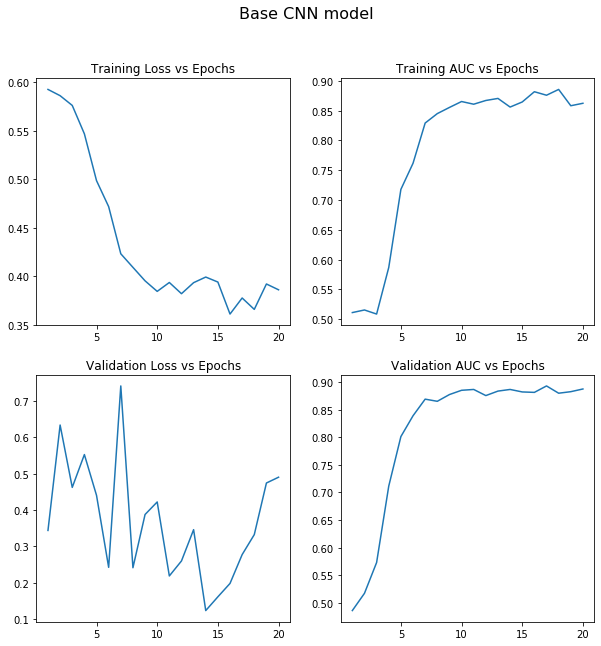

In [14]:
#visualization of accuracies and losses

#this list store results of trainig data so it can be used in comparing with other models.
ACCURACY_LIST = []

#storing the history into accuracy_list list
model.save('covid19_xray_base_cnn_model.h5')
ACCURACY_LIST.append(['Base CNN Model', history])

#initializing the figures to plot
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

#the graphs showing training losses and accuracies for epoches
sns.lineplot(x=np.arange(1, 21), y=history.history.get('loss'), ax=ax[0, 0])
sns.lineplot(x=np.arange(1, 21), y=history.history.get('auc'), ax=ax[0, 1])

#the raphs showing validation losses and accuracies of epoches
sns.lineplot(x=np.arange(1, 21), y=history.history.get('val_loss'), ax=ax[1, 0])
sns.lineplot(x=np.arange(1, 21), y=history.history.get('val_auc'), ax=ax[1, 1])

#Setting the lebels for the graph
ax[0, 0].set_title('Training Loss vs Epochs')
ax[0, 1].set_title('Training AUC vs Epochs')
ax[1, 0].set_title('Validation Loss vs Epochs')
ax[1, 1].set_title('Validation AUC vs Epochs')

#displaying the graphs in the plot
fig.suptitle('Base CNN model', size=16)
plt.show()

In [19]:
#functions for determining accuracies 

# function used for checking the accuarcy of data set 
def get_accuracy(predicted, labels):
    batch_len, correct= 0, 0
    batch_len = labels.size(0)
    
    #when predicted value is equal to labels them add it th correct variable
    correct = (predicted == labels).sum().item()
    
    #returns lenght of batch and the number of correctly predicted data.
    return batch_len, correct

#function for determining the losses and accuarcies
def evaluate(model, val_loader):
    losses= 0
    num_samples_total=0
    correct_total=0
    
    #evaluating the model
    model.eval()
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        out = model(inputs)
        _, predicted = torch.max(out, 1)
        loss = criterion(out, labels)
        losses += loss.item() 
        b_len, corr = get_accuracy(predicted, labels)
        num_samples_total +=b_len
        correct_total +=corr
        
    #determining accuracy    
    accuracy = correct_total/num_samples_total
    #determining losses
    losses = losses/len(val_loader)
    return losses, accuracy

In [119]:
#calculating accuracy of training data

test_acc = round((max(history.history.get('accuracy'))* 100 ),2)
print("The testing accuracy of Base CNN is" , test_acc, "%" )

The testing accuracy of Base CNN is 84.5 %


We are able to acheive an accuaracy of 84.50% by using Base CNN model. But we observe that there is an imbalance in data. To compensate this we can increase epoch numbers.


# Training ResNet50 model

As we have used simple neural netwrok in our previous model. I would like to add more deep layers to increase the accuracy. so i went ahead with ResNet50 model. The ResNet stands for residual learning. 50 indicate number of layers. The main idea is to go deeper into layer to increase classification and accuracy. The results of one layer will be forwarded to next layer.

In [116]:
##initilizing the ResNet model

classes = ['Normal','Pnemonia']
num_classes = len(classes)

#importing ResNet50 from torchvision library
net = torchvision.models.resnet50(pretrained = True)

# We replace last layer of resnet to match our number of classes which is 2
net.fc = nn.Linear(512, num_classes)
net = net.to(device)

In [67]:
#Asigning loss function and optimizer for model

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-5)

#displaying model to know the layers used inside it
print(net)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [90]:

#defining metrics that should be displyed in epoches
METRICS = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'), 
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='auc'),
]

#using the ResNet model
def output_custom_model(prebuilt_model):
    print(f"Processing {prebuilt_model}")
    prebuilt = prebuilt_model(include_top=False,
                            input_shape=(224, 224, 3),
                            weights='imagenet')
    
    #the last layer is again going through some layering
    output = prebuilt.output
    output = GlobalMaxPooling2D()(output)
    output = Dense(128, activation='relu')(output)
    output = Dropout(0.2)(output)
    output = Dense(1, activation='sigmoid')(output)
    
    #compiling ResNet model
    model = Model(inputs=prebuilt.input, outputs=output)
    model.compile(optimizer='sgd', loss=binary_crossentropy,
              metrics=METRICS)
    return model

In [93]:

#fitting the model to the training data
#number of epoches used is 30

resnet_custom_model = output_custom_model(ResNet50)
resnet_history = resnet_custom_model.fit_generator(train_generator,
                                 epochs=30,
                                 validation_data=validation_generator,
                                 callbacks=[custom_callback])
print('Finished Training')

Processing <function keras_modules_injection.<locals>.wrapper at 0x000001E889BC04C8>
Epoch 1/30


C:\Users\srava\anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\srava\anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


125/125 [==============================] - 1448s 12s/step - loss: 1.4168 - tp: 601.0000 - fp: 141.0000 - tn: 99.0000 - fn: 159.0000 - accuracy: 0.7000 - precision: 0.8100 - recall: 0.7908 - auc: 0.6489 - val_loss: 0.8017 - val_tp: 1540.0000 - val_fp: 661.0000 - val_tn: 441.0000 - val_fn: 1644.0000 - val_accuracy: 0.4622 - val_precision: 0.6997 - val_recall: 0.4837 - val_auc: 0.4239
Epoch 2/30
125/125 [==============================] - 1159s 9s/step - loss: 0.8374 - tp: 664.0000 - fp: 111.0000 - tn: 129.0000 - fn: 96.0000 - accuracy: 0.7930 - precision: 0.8568 - recall: 0.8737 - auc: 0.7908 - val_loss: 1.0368 - val_tp: 492.0000 - val_fp: 161.0000 - val_tn: 941.0000 - val_fn: 2692.0000 - val_accuracy: 0.3343 - val_precision: 0.7534 - val_recall: 0.1545 - val_auc: 0.5172
Epoch 3/30
125/125 [==============================] - 1098s 9s/step - loss: 0.5375 - tp: 683.0000 - fp: 82.0000 - tn: 158.0000 - fn: 77.0000 - accuracy: 0.8410 - precision: 0.8928 - recall: 0.8987 - auc: 0.8720 - val_loss

# Visulaization of accuracies of ResNet50 model

The visualization gives us more idea about accuracies and losses occured in training process. The graphs are plotted between training loss and validation loss. Similarly between training and validation accuracies.

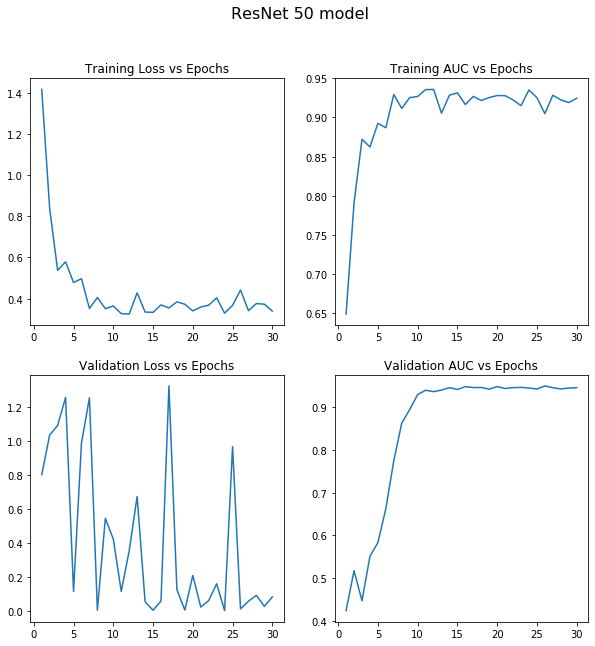

In [96]:
#stroring the reuslt in Acuuracy_list for comparision
resnet_custom_model.save('covid19_xray_resnet_50.h5')
ACCURACY_LIST.append(['ResNet 50', resnet_history])

#initializing plots
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

#Graphs of trainig losses and accuracies with epoches
sns.lineplot(x=np.arange(1, 31), y=resnet_history.history.get('loss'), ax=ax[0, 0])
sns.lineplot(x=np.arange(1, 31), y=resnet_history.history.get('auc'), ax=ax[0, 1])

#Graphs showing validation losses and accuracies
sns.lineplot(x=np.arange(1, 31), y=resnet_history.history.get('val_loss'), ax=ax[1, 0])
sns.lineplot(x=np.arange(1, 31), y=resnet_history.history.get('val_auc'), ax=ax[1, 1])

#setting titles for graphs
ax[0, 0].set_title('Training Loss vs Epochs')
ax[0, 1].set_title('Training AUC vs Epochs')
ax[1, 0].set_title('Validation Loss vs Epochs')
ax[1, 1].set_title('Validation AUC vs Epochs')

#displaying graphs
fig.suptitle('ResNet 50 model', size=16)
plt.show()

In [118]:
#calculating accuracy of training data

test_acc = round((max(resnet_history.history.get('accuracy'))* 100 ),2)
print("The testing accuracy of ResNet model is" , test_acc, "%" )

The testing accuracy of ResNet model is 88.8 %


We are able to acheive an acuarcy of 88.8 % with Resenet model which is almost near to 90 %

# Comparing models :


The ACCURACY_LIST has all the model results. So we can use this list to compare both the models. the graph will give a better understanding of model values.

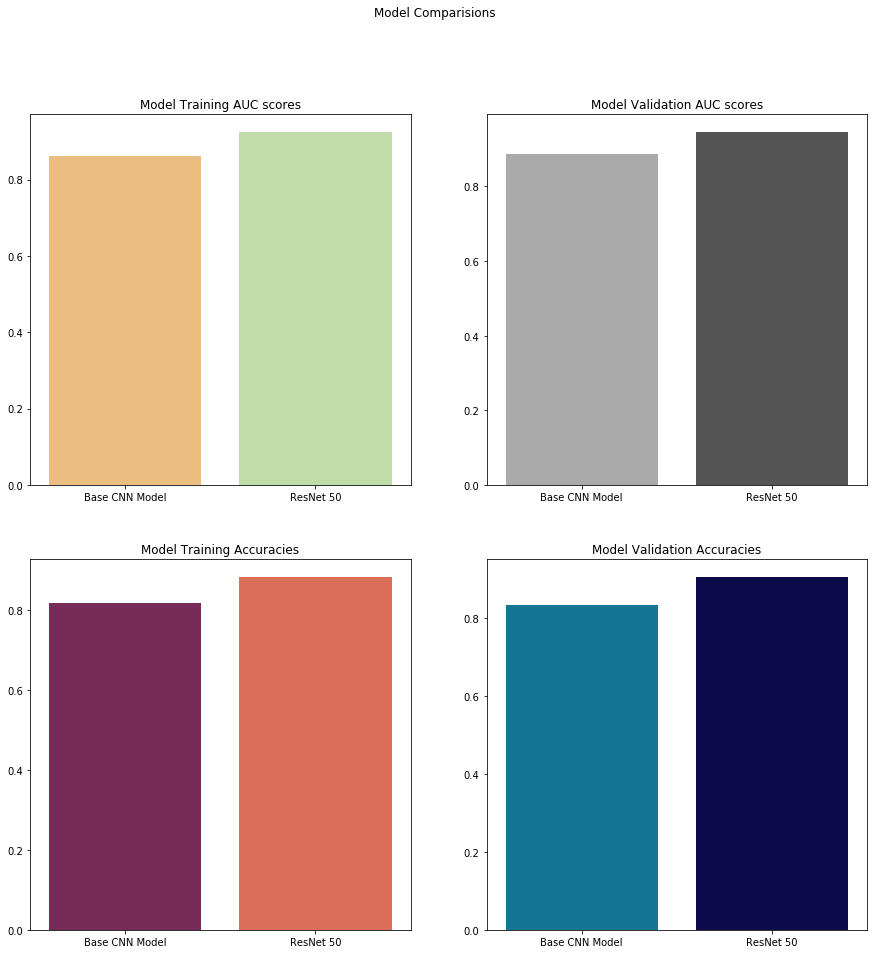

In [102]:

#consists of details about both models
ACCURACY_LIST = np.array(ACCURACY_LIST)
model_names = ACCURACY_LIST[:, 0]
histories = ACCURACY_LIST[:, 1]

#plotting the graphs
fig, ax = plt.subplots(2, 2, figsize=(15, 15))

#graphs comparing training and validation auc score
sns.barplot(x=model_names, y=list(map(lambda x: x.history.get('auc')[-1], histories)), ax=ax[0, 0], palette='Spectral')
sns.barplot(x=model_names, y=list(map(lambda x: x.history.get('val_auc')[-1], histories)), ax=ax[0, 1], palette='gist_yarg')

#graphs comparing training and validation accuracies
sns.barplot(x=model_names, y=list(map(lambda x: x.history.get('accuracy')[-1], histories)), ax=ax[1, 0], palette='rocket')
sns.barplot(x=model_names, y=list(map(lambda x: x.history.get('val_accuracy')[-1], histories)), ax=ax[1, 1], palette='ocean_r')

#mapping the titles for graphs
ax[0, 0].set_title('Model Training AUC scores')
ax[0, 1].set_title('Model Validation AUC scores')
ax[1, 0].set_title('Model Training Accuracies')
ax[1, 1].set_title('Model Validation Accuracies')

#displaying the graphs
fig.suptitle('Model Comparisions')
plt.show()